# Timo's notes on building an RNN with PyTorch 
Our first target is the classification of (German) verbs vs. adjectives. The classifier that we build on this basis will, however, be able to learn to classify any type of character sequence.

- Potentially, we could simply use the last 3 characters of the word and feed these features into a (very normal! feed-forward) neural network. It would have ~26*3 input neurons (unless we have more different characters, which might very well be the case) and number_of_classes output neurons (for two classes we could get by with just one neuron). There will also be an hidden/inner layer with some dimensionality.
- the approach sketched above does not scale to longer sequences (where the interesting parts might not be the last three characters). In particular, sequences have different lengths, they might also be shorter than 3 characters!
- we differentiate between two parts of the classifier: we first _encode_ the sequence and we then classify based on this encoding.

In [5]:
import torch
import torch.nn as nn
import ipywidgets as widgets
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
# we will often repeatedly use some code for plotting. We define this once to be re-used later.
def plot(plot_data):
    plt.figure("evolution over training iterations")
    for type in plot_data.keys():
       plt.plot(plot_data[type], label=type)
    plt.legend(loc='upper right')

In [7]:
# code for loading two lists of training items from separate files.
# let's use the following data layout:
# - we have a central list (data, or training, or test, or the like) which contains
# - pairs of (class-assignment, data-to-be-classified).
# - (we could also have a list "apply" in which case we would not have any class-assignments, obviously)
# - we'll have a list "CLASS_NAMES" and therefore the class-assignment will be a number (index into the class_names list)
# - data-to-be-classified is again a list (sequence data, right?)
# - our sequence data is characters. 
CLASS_NAMES = []

def load_class_from_file(filename, class_name=None) -> list:
    if class_name is None:
        class_name = filename
    if not class_name in CLASS_NAMES:
        CLASS_NAMES.append(class_name)
    class_index = CLASS_NAMES.index(class_name)
    with open(filename, 'r') as f:
        data = [[class_index, l.strip()] for l in f.readlines()]
    return data
data = load_class_from_file('data/adjektive.words', 'adjektive')
data.extend(load_class_from_file('data/verben.words', 'verben'))
random.shuffle(data)
print(list(enumerate(CLASS_NAMES)))
print(data[0:4])

[(0, 'adjektive'), (1, 'verben')]
[[0, 'wachsende'], [0, 'gescheiterten'], [1, 'berichten'], [1, 'eingesetzt']]


In [8]:
# the data cannot yet be put to use,
# we still need to convert the input into numbers that can be used as input into the NN.
CHARACTERS = set()
for d in data:
    CHARACTERS = CHARACTERS.union(d[1])
NUM_CHARACTERS = len(CHARACTERS)
int_to_char = sorted(CHARACTERS)
char_to_int = {c:i for i,c in enumerate(CHARACTERS)}
for d in data:
    d.append([char_to_int[c] for c in d[1]])
print(int_to_char)
print(data[0:4])

['-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ä', 'ß', 'ä', 'ö', 'ü']
[[0, 'wachsende', [30, 50, 54, 47, 39, 12, 61, 34, 12]], [0, 'gescheiterten', [8, 12, 39, 54, 47, 12, 52, 40, 12, 15, 40, 12, 61]], [1, 'berichten', [2, 12, 15, 52, 54, 47, 40, 12, 61]], [1, 'eingesetzt', [12, 52, 61, 8, 12, 39, 12, 40, 36, 40]]]


In [9]:
INPUT_SIZE = NUM_CHARACTERS
HIDDEN_SIZE = 64
# okay, what's a recurrent neural network anyway? see https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recurrent-neural-network/recurrent_neural_networks
# At every time step, we have an input, 
class RNN_Layer(nn.Module):
    def __init__(self):
        super(RNN_Layer, self).__init__()
        self.Wx = nn.Parameter(nn.init.xavier_uniform_(torch.empty(INPUT_SIZE, HIDDEN_SIZE)))
        self.Wh = nn.Parameter(nn.init.xavier_uniform_(torch.empty(HIDDEN_SIZE, HIDDEN_SIZE)))
        self.b = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, HIDDEN_SIZE)))
#        self.Wx = nn.Linear(INPUT_SIZE, HIDDEN_SIZE, bias=false)
#        self.Wh = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=true)

    def step(self, x: torch.Tensor, state : torch.Tensor) -> torch.Tensor:
        return nn.functional.tanh(x @ self.Wx + state @ self.Wh + self.b)
        # or: return nn.functional.tanh(self.Wx(x) + self.Wh(x))
    
    def forward(self, xs : list) -> torch.Tensor:
        xs = [torch.nn.functional.one_hot(torch.tensor(x), num_classes=INPUT_SIZE).float() for x in xs]
        state = torch.zeros(1, HIDDEN_SIZE)
        for x in xs:
            state = self.step(x, state)
        return state

In [10]:
NUM_CLASSES = len(CLASS_NAMES)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.rnn = RNN_Layer()
        self.final_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, xs : list):
        sequence_encoding = self.rnn(xs)
        result = nn.functional.softmax(self.final_layer(sequence_encoding), dim=1)
        return result

Epoch 0 starting
Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting


Classifier(
  (rnn): RNN_Layer()
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
)

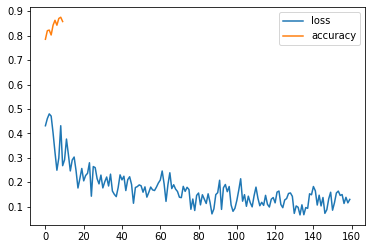

In [11]:
def training():
    train, test = torch.utils.data.random_split(data, [0.8, 0.2])
    #print(list(train)[0:4])
    classify = Classifier()
    plot_data = defaultdict(lambda : [])
    optimizer = torch.optim.Adam(classify.parameters())
    plot_every = 100
    training_counter = 1
    
    for epoch in range(10):
        print(("Epoch {} starting".format(epoch)))
        random.shuffle(train.indices)
        aggr_loss = 0
        for cls, words, ints in train:
            optimizer.zero_grad()
            output = classify(ints)
            loss  = nn.functional.nll_loss(output, torch.tensor([cls]))
            loss.backward()
            aggr_loss += 1 + loss.item()
            optimizer.step()
            if training_counter % plot_every == 0:
                plot_data["loss"].append(aggr_loss / plot_every)
                aggr_loss = 0
            training_counter += 1
        
        # test performance of classifier:
        correct = 0
        for cls, _, ints in test:
            output = classify(ints)
            prediction = int(torch.topk(output, 1)[1].item())
            correct += 1 if prediction == cls else 0
        plot_data["accuracy"].append(correct / len(test))

    plot(plot_data)
    return classify

training()

Epoch 0 starting
Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting


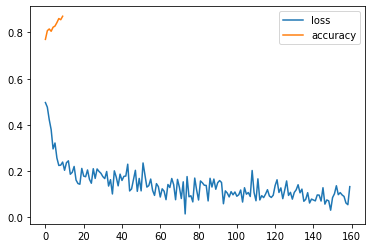

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.rnn = nn.GRU(INPUT_SIZE, HIDDEN_SIZE, 1) # RNN or LSTM or GRU
        self.final_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, xs : list):
        xs = torch.nn.functional.one_hot(torch.tensor(xs), num_classes=INPUT_SIZE).float()
        rnn_output, hidden_states = self.rnn(xs)
        final_output = rnn_output[-1].reshape(1,HIDDEN_SIZE)
        return nn.functional.softmax(self.final_layer(final_output), dim=1)

training()

Epoch 0 starting
Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting


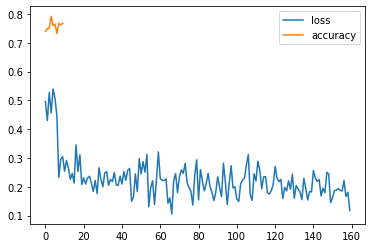

In [86]:
INPUT_SIZE = 16

class Embeddings(nn.Module):
    def __init__(self):
        super(Embeddings, self).__init__()
        self.W = nn.Linear(NUM_CHARACTERS, INPUT_SIZE, bias=False)

    def forward(self, xs : list):
        xs = self.W(torch.nn.functional.one_hot(torch.tensor(xs), num_classes=NUM_CHARACTERS).float())
        return xs
        

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.embed = Embeddings()
        self.rnn = nn.RNN(INPUT_SIZE, HIDDEN_SIZE, 1)
        self.final_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, xs : list):
        xs = self.embed(xs)
        rnn_output, hidden_states = self.rnn(xs)
        final_output = rnn_output[-1].reshape(1,HIDDEN_SIZE)
        return nn.functional.softmax(self.final_layer(final_output), dim=1)

training()